# [House Price Predicting]('https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview')

## `Importing`

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
import torch 
import torch.nn as nn
import torch.nn.functional as F 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

#### `Loading The Data`

In [2]:
df = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')

## `Exploratory Data Analysis`

In [3]:
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.shape 

(1460, 81)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### `Getting the statistical summary of dataset`

In [6]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


#### `Visualizing the correlations between numerical variables`

/var/folders/9b/k35zb79j27vcvxd_45b3jpd80000gn/T/ipykernel_1445/2415724932.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap="RdBu")


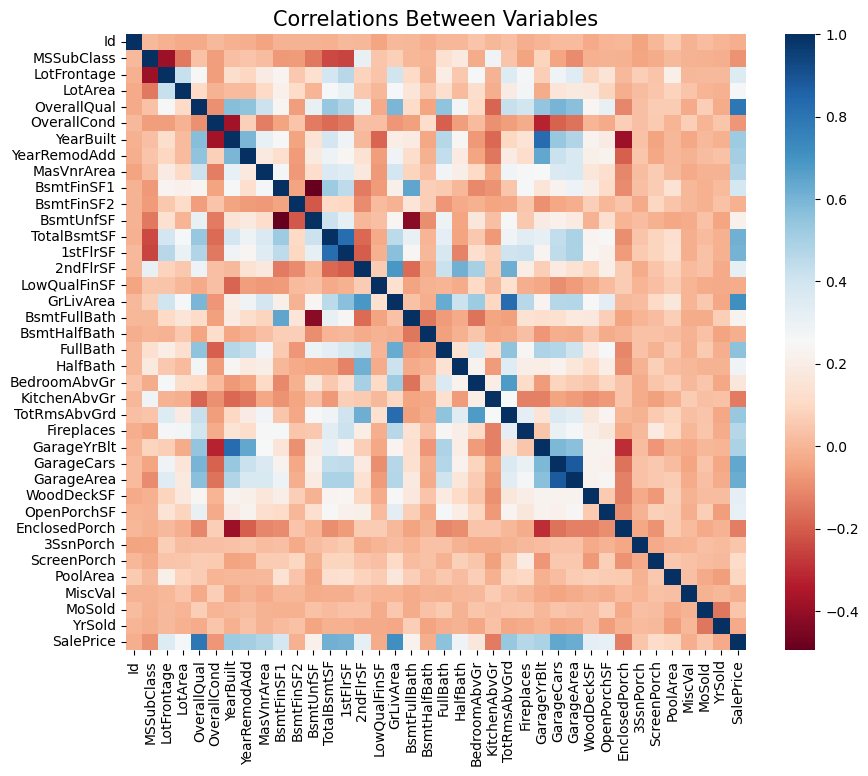

In [7]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

## `Feature Selection`


#### `Changing YearBuilt --> Total Years`

In [8]:
df['Total Years'] = datetime.datetime.now().year - df['YearBuilt']
df.drop("YearBuilt", axis = 1 , inplace=True)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total Years
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,20
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,47
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,22
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,108
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,23


#### `Creating Categorical Features`

In [9]:
# numerical columns
important_num_cols = list(df.corr()["SalePrice"][(df.corr()["SalePrice"]>0.50) | (df.corr()["SalePrice"]<-0.50)].index)

categorical_features = ["MSSubClass", "MSZoning", "Street", "Utilities", "BldgType", "Heating", "KitchenQual", "SaleCondition", "LandSlope", "LotShape"]

important_cols = important_num_cols + categorical_features

df = df[important_cols]
df.head()

/var/folders/9b/k35zb79j27vcvxd_45b3jpd80000gn/T/ipykernel_1445/3592068013.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  important_num_cols = list(df.corr()["SalePrice"][(df.corr()["SalePrice"]>0.50) | (df.corr()["SalePrice"]<-0.50)].index)


,OverallQual,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice,...,MSSubClass,MSZoning,Street,Utilities,BldgType,Heating,KitchenQual,SaleCondition,LandSlope,LotShape
0,7,2003,856,856,1710,2,8,2,548,208500,...,60,RL,Pave,AllPub,1Fam,GasA,Gd,Normal,Gtl,Reg
1,6,1976,1262,1262,1262,2,6,2,460,181500,...,20,RL,Pave,AllPub,1Fam,GasA,TA,Normal,Gtl,Reg
2,7,2002,920,920,1786,2,6,2,608,223500,...,60,RL,Pave,AllPub,1Fam,GasA,Gd,Normal,Gtl,IR1
3,7,1970,756,961,1717,1,7,3,642,140000,...,70,RL,Pave,AllPub,1Fam,GasA,Gd,Abnorml,Gtl,IR1
4,8,2000,1145,1145,2198,2,9,3,836,250000,...,60,RL,Pave,AllPub,1Fam,GasA,Gd,Normal,Gtl,IR1


#### `Creating Continuous variables`

In [10]:
cont_features = []

for i in df.columns:
      if i in ["MSSubClass", "MSZoning", "Street", "Utilities", "BldgType", "Heating", "KitchenQual", "SaleCondition", "LandSlope", "LotShape", "SalePrice"]:
            pass
      else:
            cont_features.append(i)
            
cont_features

['OverallQual',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'Total Years']

In [11]:
for i in df.columns:
      print(f'Column name "{i}" and unique are ({len(df[i].unique())})')

Column name "OverallQual" and unique are (10)
Column name "YearRemodAdd" and unique are (61)
Column name "TotalBsmtSF" and unique are (721)
Column name "1stFlrSF" and unique are (753)
Column name "GrLivArea" and unique are (861)
Column name "FullBath" and unique are (4)
Column name "TotRmsAbvGrd" and unique are (12)
Column name "GarageCars" and unique are (5)
Column name "GarageArea" and unique are (441)
Column name "SalePrice" and unique are (663)
Column name "Total Years" and unique are (112)
Column name "MSSubClass" and unique are (15)
Column name "MSZoning" and unique are (5)
Column name "Street" and unique are (2)
Column name "Utilities" and unique are (2)
Column name "BldgType" and unique are (5)
Column name "Heating" and unique are (6)
Column name "KitchenQual" and unique are (4)
Column name "SaleCondition" and unique are (6)
Column name "LandSlope" and unique are (3)
Column name "LotShape" and unique are (4)


In [12]:
df.shape

(1460, 21)

In [13]:
print(df.isnull().sum())
print("TOTAL MISSING VALUES:",df.isna().sum().sum())


OverallQual      0
YearRemodAdd     0
TotalBsmtSF      0
1stFlrSF         0
GrLivArea        0
FullBath         0
TotRmsAbvGrd     0
GarageCars       0
GarageArea       0
SalePrice        0
Total Years      0
MSSubClass       0
MSZoning         0
Street           0
Utilities        0
BldgType         0
Heating          0
KitchenQual      0
SaleCondition    0
LandSlope        0
LotShape         0
dtype: int64
TOTAL MISSING VALUES: 0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OverallQual    1460 non-null   int64 
 1   YearRemodAdd   1460 non-null   int64 
 2   TotalBsmtSF    1460 non-null   int64 
 3   1stFlrSF       1460 non-null   int64 
 4   GrLivArea      1460 non-null   int64 
 5   FullBath       1460 non-null   int64 
 6   TotRmsAbvGrd   1460 non-null   int64 
 7   GarageCars     1460 non-null   int64 
 8   GarageArea     1460 non-null   int64 
 9   SalePrice      1460 non-null   int64 
 10  Total Years    1460 non-null   int64 
 11  MSSubClass     1460 non-null   int64 
 12  MSZoning       1460 non-null   object
 13  Street         1460 non-null   object
 14  Utilities      1460 non-null   object
 15  BldgType       1460 non-null   object
 16  Heating        1460 non-null   object
 17  KitchenQual    1460 non-null   object
 18  SaleCondition  1460 non-null

### `Data Visualization`
#### `Visualizing the Correlation between the numerical variables`

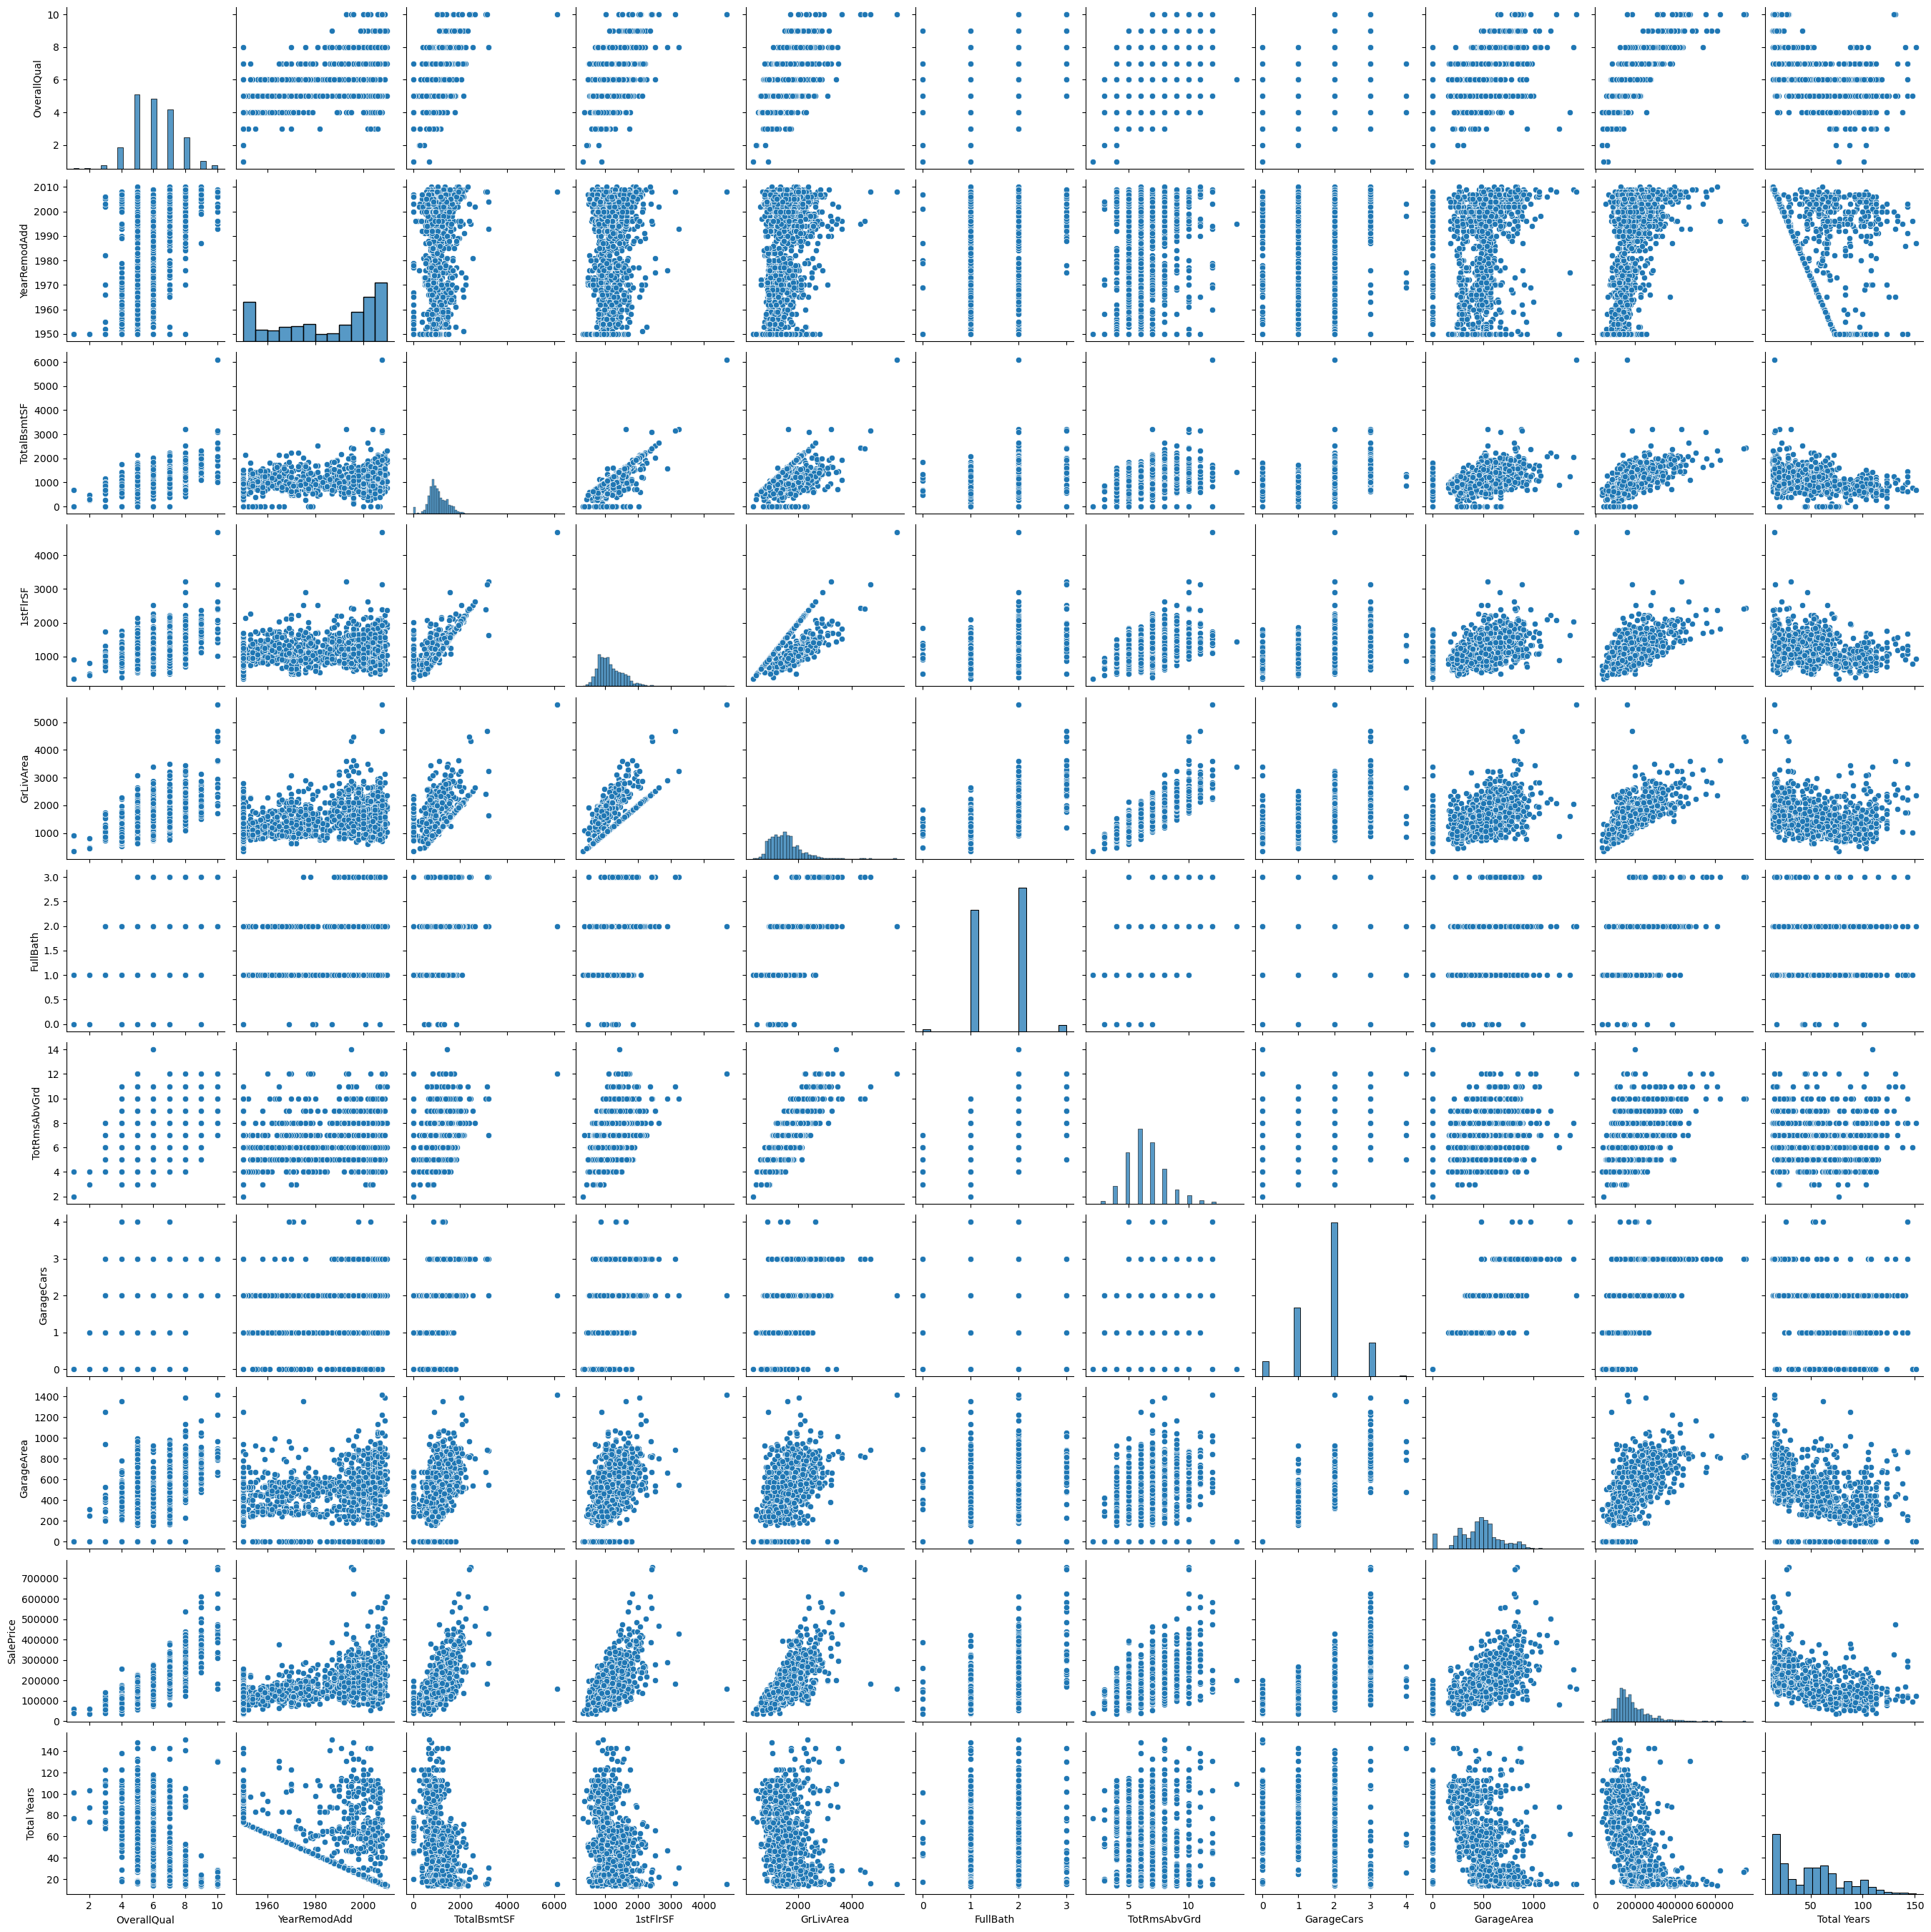

In [15]:
sns.pairplot(df[important_num_cols]);


#### `Changing Dates`

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OverallQual    1460 non-null   int64 
 1   YearRemodAdd   1460 non-null   int64 
 2   TotalBsmtSF    1460 non-null   int64 
 3   1stFlrSF       1460 non-null   int64 
 4   GrLivArea      1460 non-null   int64 
 5   FullBath       1460 non-null   int64 
 6   TotRmsAbvGrd   1460 non-null   int64 
 7   GarageCars     1460 non-null   int64 
 8   GarageArea     1460 non-null   int64 
 9   SalePrice      1460 non-null   int64 
 10  Total Years    1460 non-null   int64 
 11  MSSubClass     1460 non-null   int64 
 12  MSZoning       1460 non-null   object
 13  Street         1460 non-null   object
 14  Utilities      1460 non-null   object
 15  BldgType       1460 non-null   object
 16  Heating        1460 non-null   object
 17  KitchenQual    1460 non-null   object
 18  SaleCondition  1460 non-null

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.00,1087.0,1391.25,4692.0
GrLivArea,1460.0,1515.463699,525.480383,334.0,1129.50,1464.0,1776.75,5642.0
FullBath,1460.0,1.565068,0.550916,0.0,1.00,2.0,2.00,3.0
TotRmsAbvGrd,1460.0,6.517808,1.625393,2.0,5.00,6.0,7.00,14.0
GarageCars,1460.0,1.767123,0.747315,0.0,1.00,2.0,2.00,4.0
GarageArea,1460.0,472.980137,213.804841,0.0,334.50,480.0,576.00,1418.0
SalePrice,1460.0,180921.195890,79442.502883,34900.0,129975.00,163000.0,214000.00,755000.0


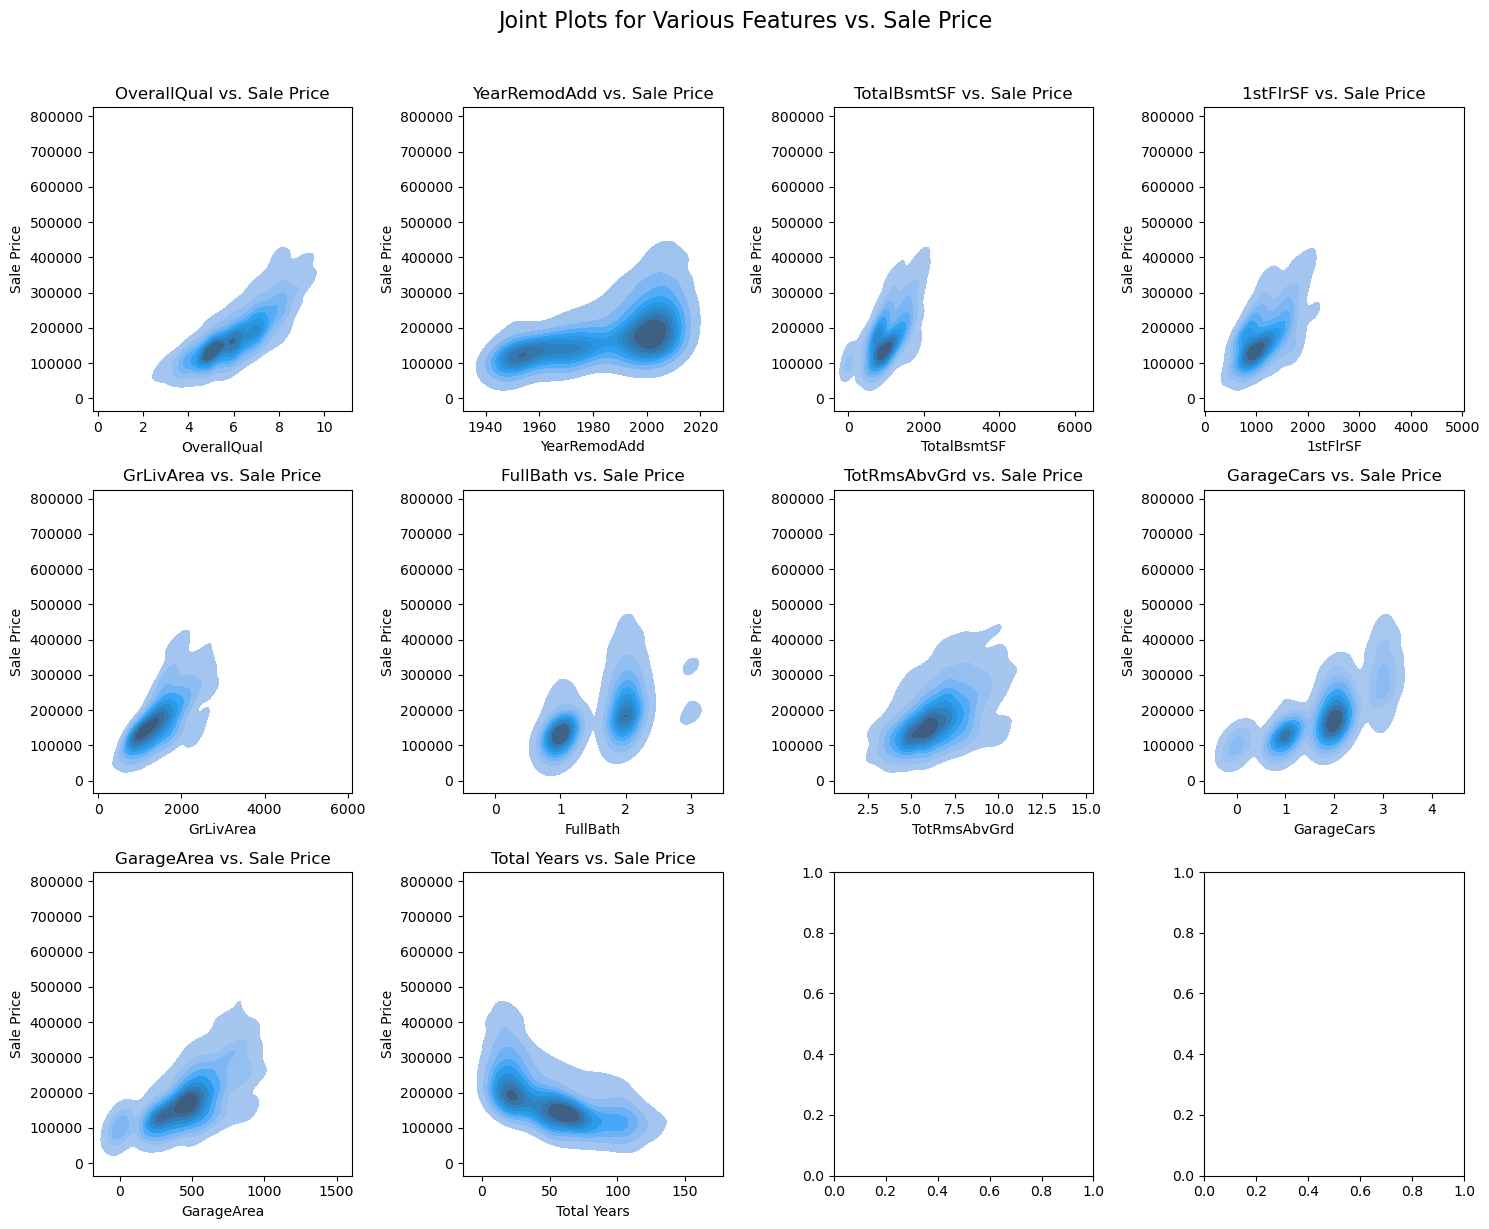

In [21]:
features = cont_features


fig, axes = plt.subplots(3, 4, figsize=(15, 12))
fig.suptitle("Joint Plots for Various Features vs. Sale Price", y=1.02, fontsize=16)

for i, feature in enumerate(features):
    row, col = divmod(i, 4)
    sns.kdeplot(x=df[feature], y=df["SalePrice"], fill=True, ax=axes[row, col])
    axes[row, col].set_title(f"{feature} vs. Sale Price")
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel("Sale Price")


plt.tight_layout()
plt.show()

### `Categorical Features Label Encoding`

In [22]:
lbl_encoders = {}

for feature in categorical_features:
      lbl_encoders[feature] = LabelEncoder()
      df[feature] = lbl_encoders[feature].fit_transform(df[feature])
      
df.head()

,OverallQual,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice,...,MSSubClass,MSZoning,Street,Utilities,BldgType,Heating,KitchenQual,SaleCondition,LandSlope,LotShape
0,7,2003,856,856,1710,2,8,2,548,208500,...,5,3,1,0,0,1,2,4,0,3
1,6,1976,1262,1262,1262,2,6,2,460,181500,...,0,3,1,0,0,1,3,4,0,3
2,7,2002,920,920,1786,2,6,2,608,223500,...,5,3,1,0,0,1,2,4,0,0
3,7,1970,756,961,1717,1,7,3,642,140000,...,6,3,1,0,0,1,2,0,0,0
4,8,2000,1145,1145,2198,2,9,3,836,250000,...,5,3,1,0,0,1,2,4,0,0


#### `Stacking and Converting Into Tensors`

In [23]:
categorical_features

['MSSubClass',
 'MSZoning',
 'Street',
 'Utilities',
 'BldgType',
 'Heating',
 'KitchenQual',
 'SaleCondition',
 'LandSlope',
 'LotShape']

In [24]:
cat_values = np.stack([ df['MSSubClass'] , df['MSZoning'], df['Street'], df['Utilities'],
                       df['BldgType'] , df['Heating'], df['KitchenQual'], df['SaleCondition'],
                       df['LandSlope'] , df['LotShape']], 1)
cat_values

array([[5, 3, 1, ..., 4, 0, 3],
       [0, 3, 1, ..., 4, 0, 3],
       [5, 3, 1, ..., 4, 0, 0],
       ...,
       [6, 3, 1, ..., 4, 0, 3],
       [0, 3, 1, ..., 4, 0, 3],
       [0, 3, 1, ..., 4, 0, 3]])

In [25]:
# Convert numpy to Tensor
cat_values = torch.tensor(cat_values, dtype=torch.int64)
cat_values

tensor([[5, 3, 1,  ..., 4, 0, 3],
        [0, 3, 1,  ..., 4, 0, 3],
        [5, 3, 1,  ..., 4, 0, 0],
        ...,
        [6, 3, 1,  ..., 4, 0, 3],
        [0, 3, 1,  ..., 4, 0, 3],
        [0, 3, 1,  ..., 4, 0, 3]])

### `Continuous variables Stacking and Converting Into Tensors`

In [26]:
cont_values = np.stack([df[i].values for i in cont_features], axis = 1)
cont_values = torch.tensor(cont_values, dtype=torch.float)
cont_values

tensor([[7.0000e+00, 2.0030e+03, 8.5600e+02,  ..., 2.0000e+00, 5.4800e+02,
         2.0000e+01],
        [6.0000e+00, 1.9760e+03, 1.2620e+03,  ..., 2.0000e+00, 4.6000e+02,
         4.7000e+01],
        [7.0000e+00, 2.0020e+03, 9.2000e+02,  ..., 2.0000e+00, 6.0800e+02,
         2.2000e+01],
        ...,
        [7.0000e+00, 2.0060e+03, 1.1520e+03,  ..., 1.0000e+00, 2.5200e+02,
         8.2000e+01],
        [5.0000e+00, 1.9960e+03, 1.0780e+03,  ..., 1.0000e+00, 2.4000e+02,
         7.3000e+01],
        [5.0000e+00, 1.9650e+03, 1.2560e+03,  ..., 1.0000e+00, 2.7600e+02,
         5.8000e+01]])

### `Dependent Feature`

In [27]:
# convert into tensors
y = torch.tensor(df['SalePrice'].values, dtype=torch.float).reshape(-1, 1)
y

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [28]:
print(df.shape)
print(cat_values.shape)
print(cont_values.shape)
print(y.shape)

(1460, 21)
torch.Size([1460, 10])
torch.Size([1460, 10])
torch.Size([1460, 1])


### `Embedding Size for Categorical columns`

In [29]:
categorical_dims = [len(df[col].unique()) for col in categorical_features]
categorical_dims

[15, 5, 2, 2, 5, 6, 4, 6, 3, 4]

In [30]:
embedding_dim = [(x, min(50, (x + 1) // 2)) for x in categorical_dims]
embedding_dim

[(15, 8),
 (5, 3),
 (2, 1),
 (2, 1),
 (5, 3),
 (6, 3),
 (4, 2),
 (6, 3),
 (3, 2),
 (4, 2)]

## `PyTorch`

#### `Creating Feed Forward Neural Network`

In [31]:
class FeedForwardNN(nn.Module):

    def __init__(self, embedding_dim, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((out for inp,out in embedding_dim))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [33]:
torch.manual_seed(100)
model = FeedForwardNN(embedding_dim, len(cont_features), 1, [100,50], p=0.4)

In [34]:
model 

FeedForwardNN(
  (embeds): ModuleList(
    (0): Embedding(15, 8)
    (1): Embedding(5, 3)
    (2-3): 2 x Embedding(2, 1)
    (4): Embedding(5, 3)
    (5): Embedding(6, 3)
    (6): Embedding(4, 2)
    (7): Embedding(6, 3)
    (8): Embedding(3, 2)
    (9): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=38, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

### `Define Loss and Optimizer`

In [35]:
model.parameters

<bound method Module.parameters of FeedForwardNN(
  (embeds): ModuleList(
    (0): Embedding(15, 8)
    (1): Embedding(5, 3)
    (2-3): 2 x Embedding(2, 1)
    (4): Embedding(5, 3)
    (5): Embedding(6, 3)
    (6): Embedding(4, 2)
    (7): Embedding(6, 3)
    (8): Embedding(3, 2)
    (9): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=38, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)>

In [36]:
loss_function = nn.MSELoss() ## Later convert to RSME
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [37]:
df.shape 

(1460, 21)

In [38]:
cont_values, cont_values.shape

(tensor([[7.0000e+00, 2.0030e+03, 8.5600e+02,  ..., 2.0000e+00, 5.4800e+02,
          2.0000e+01],
         [6.0000e+00, 1.9760e+03, 1.2620e+03,  ..., 2.0000e+00, 4.6000e+02,
          4.7000e+01],
         [7.0000e+00, 2.0020e+03, 9.2000e+02,  ..., 2.0000e+00, 6.0800e+02,
          2.2000e+01],
         ...,
         [7.0000e+00, 2.0060e+03, 1.1520e+03,  ..., 1.0000e+00, 2.5200e+02,
          8.2000e+01],
         [5.0000e+00, 1.9960e+03, 1.0780e+03,  ..., 1.0000e+00, 2.4000e+02,
          7.3000e+01],
         [5.0000e+00, 1.9650e+03, 1.2560e+03,  ..., 1.0000e+00, 2.7600e+02,
          5.8000e+01]]),
 torch.Size([1460, 10]))

### `Train Test Split`

In [39]:
batch_size = 1200
test_size = int(batch_size*0.15)

train_categorical = cat_values[:batch_size-test_size]
test_categorical = cat_values[batch_size-test_size:batch_size]

train_cont = cont_values[:batch_size-test_size]
test_cont = cont_values[batch_size-test_size:batch_size]

y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [41]:
print(len(train_categorical),len(test_categorical), 
      len(train_cont),len(test_cont),
      len(y_train),len(y_test))


1020 180 1020 180 1020 180


In [42]:
epochs = 5001
final_losses = []

for i in range(epochs):
      
    y_pred = model(train_categorical,train_cont)
    loss = torch.sqrt(loss_function(y_pred,y_train)) ### RMSE
    final_losses.append(loss.item())
    
    if i%500 == 0:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch number: 0 and the loss : 198494.96875
Epoch number: 500 and the loss : 194393.625
Epoch number: 1000 and the loss : 182332.234375
Epoch number: 1500 and the loss : 164655.546875
Epoch number: 2000 and the loss : 141893.5
Epoch number: 2500 and the loss : 117049.4140625
Epoch number: 3000 and the loss : 92498.3828125
Epoch number: 3500 and the loss : 67627.71875
Epoch number: 4000 and the loss : 44143.33203125
Epoch number: 4500 and the loss : 31378.125
Epoch number: 5000 and the loss : 32300.634765625


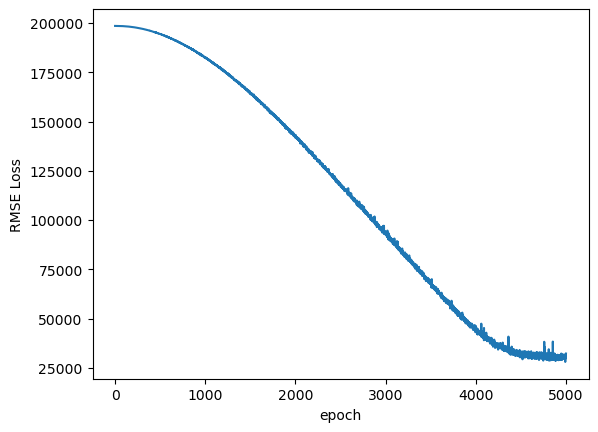

In [43]:
plt.plot(range(epochs), final_losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

### `Validate the Test Data`

In [44]:
y_pred = ''
with torch.no_grad():
      y_pred = model(test_categorical, test_cont)
      loss = torch.sqrt(loss_function(y_pred, y_test))
                        
print(f"RMSE: {loss}")

RMSE: 35489.30078125


In [45]:
data_verify = pd.DataFrame(y_test.tolist(), columns=['Test'])
data_predicted = pd.DataFrame(y_pred.tolist(), columns=['Prediction'])
data_predicted.head()

,Prediction
0,140630.078125
1,162615.671875
2,115377.070312
3,247459.390625
4,281837.625000


In [46]:
final_output = pd.concat([data_verify, data_predicted], axis=1)
final_output['Difference'] = final_output['Test'] - final_output['Prediction']
final_output.head()

,Test,Prediction,Difference
0,176000.0,140630.078125,35369.921875
1,194000.0,162615.671875,31384.328125
2,87000.0,115377.070312,-28377.070312
3,191000.0,247459.390625,-56459.390625
4,287000.0,281837.625000,5162.375000


In [47]:
final_output.describe()

,Test,Prediction,Difference
count,180.000000,180.000000,180.000000
mean,179758.933333,175758.841949,4000.091385
std,87464.020515,81702.696310,35361.514918
min,60000.000000,61791.902344,-80374.953125
25%,128750.000000,125722.828125,-19766.375000
50%,164450.000000,154696.148438,4227.593750
75%,200230.750000,198635.656250,21543.882812
max,745000.000000,778049.812500,201342.000000
